In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
import torch 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# # !pip install -U pip > /dev/null
# !pip install bio_embeddings[all]

In [3]:
df = pd.read_csv('../input/anti-microbial-peptides-data/data/AMP_dataset.csv')
# df = pd.read_csv('../input/anti-microbial-peptides-data/Datasets/Generative model dataset/amp_dataset.csv', names = ['PepSeq', 'MIC'])


In [4]:
df

,Database,PepID,PepType,PepSeq,PepLabel,ADAM_HMM,ADAM_SVM,AMPA,CMPR3_ANN,CMPR3_DA,CMPR3_RF,CMPR3_SVM,DBAASP
0,A,A00001,T,GLWSKIKEVGKEAAKAAAKAAGKAALGAVSEAV,1,1,1,0.00,1,0.999,0.9355,0.957,1
1,A,A00002,T,YVPLPNVPQPGRRPFPTFPGQGPFNPKIKWPQGY,1,1,1,0.00,0,0.047,0.5810,0.500,1
2,A,A00003,T,NLCERASLTWTGNCGNTGHCDTQCRNWESAKHGACHKRGNWKCFCYFDC,1,1,1,0.96,1,0.971,0.9130,0.873,0
3,A,A00004,T,VFIDILDKVENAIHNAAQVGIGFAKPFEKLINPK,1,1,1,0.00,1,0.943,0.7955,0.842,1
4,A,A00005,T,GNNRPVYIPQPRPPHPRI,1,1,1,0.00,1,0.941,0.9655,0.870,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20719,D,D04804,T,VMFNTFKMRHDVTKTIRNFLDTEDFLEVETPILTKSTPEGARDYLV...,0,0,0,0.00,0,1.000,0.9470,1.000,-999
20720,D,D04806,T,AIENGATAYLAEEDYGVSVPVILVKNVRKALSLAAQLYFDFPQNDL...,0,0,0,0.00,0,1.000,0.9205,1.000,-999
20721,D,D04807,T,WGLTNEEVALADEIVTFPVNPAFASLNIAQAVLLMSYEWMKSGMDD...,0,0,0,0.00,0,1.000,0.9575,1.000,-999
20722,D,D04831,T,TADELEVGMGKVGMPLRVAVTGAGQSPALDVTVHAIGKSRSVDRIN...,0,0,0,0.00,1,1.000,-999.0000,1.000,-999


In [5]:
# df.PepType.value_counts()

The training data were defined as each residue excluding the last residue of
the sequence, while the targets were the respective next residues for each position. For
example, for the sequence VDKGSYRPRPTPPKPIYNRN, VDKGSYRPRPTPPKPIYNR was
the training data, and DKGSYRPRPTPPKPIYNRN the target.

In [6]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizer_v2 import rmsprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io
import pandas as pd

In [7]:
def splitter(seq):
    seqs = []
    for s in seq:
        seqs.append(s)
    return seqs

In [8]:
df.loc[:, 'PepSeq'] = df.PepSeq.map(splitter)


In [9]:
df.head()

,Database,PepID,PepType,PepSeq,PepLabel,ADAM_HMM,ADAM_SVM,AMPA,CMPR3_ANN,CMPR3_DA,CMPR3_RF,CMPR3_SVM,DBAASP
0,A,A00001,T,"[G, L, W, S, K, I, K, E, V, G, K, E, A, A, K, ...",1,1,1,0.00,1,0.999,0.9355,0.957,1
1,A,A00002,T,"[Y, V, P, L, P, N, V, P, Q, P, G, R, R, P, F, ...",1,1,1,0.00,0,0.047,0.5810,0.500,1
2,A,A00003,T,"[N, L, C, E, R, A, S, L, T, W, T, G, N, C, G, ...",1,1,1,0.96,1,0.971,0.9130,0.873,0
3,A,A00004,T,"[V, F, I, D, I, L, D, K, V, E, N, A, I, H, N, ...",1,1,1,0.00,1,0.943,0.7955,0.842,1
4,A,A00005,T,"[G, N, N, R, P, V, Y, I, P, Q, P, R, P, P, H, ...",1,1,1,0.00,1,0.941,0.9655,0.870,1


In [10]:
text = list(df.PepSeq)

In [11]:
print(text[7:9])

[['R', 'R', 'I', 'R', 'P', 'R', 'P', 'P', 'R', 'L', 'P', 'R', 'P', 'R', 'P', 'R', 'P', 'L', 'P', 'F', 'P', 'R', 'P', 'G', 'P', 'R', 'P', 'I', 'P', 'R', 'P', 'L', 'P', 'F', 'P', 'R', 'P', 'G', 'P', 'R', 'P', 'I', 'P', 'R', 'P', 'L', 'P', 'F', 'P', 'R', 'P', 'G', 'P', 'R', 'P', 'I', 'P', 'R', 'P', 'L'], ['W', 'N', 'P', 'F', 'K', 'E', 'L', 'E', 'R', 'A', 'G', 'Q', 'R', 'V', 'R', 'D', 'A', 'V', 'I', 'S', 'A', 'A', 'P', 'A', 'V', 'A', 'T', 'V', 'G', 'Q', 'A', 'A', 'A', 'I', 'A', 'R', 'G']]


In [12]:

# path = get_file(
#     'nietzsche.txt',
#     origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
# with io.open(path, encoding='utf-8') as f:
#     text = f.read().lower()


In [13]:
import itertools

corpus = list(itertools.chain.from_iterable(text))
corpus.append('\n')

In [14]:
print('corpus length:', len(text))

chars = sorted(list(set(corpus)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

corpus length: 20724
total chars: 25


In [15]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 21
sentences = []
next_chars = []
for i, t in enumerate(text):
    if len(t) < maxlen:
        sentences.append(t)
        t = t[1:] + ['\n']
        next_chars.append(t)
print('nb sequences:', len(sentences))


nb sequences: 4409


In [16]:
# print('Vectorization...')
# x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
# y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
# for i, sentence in enumerate(sentences):
#     for t, char in enumerate(sentence):
#         x[i, t, char_indices[char]] = 1
#     y[i, char_indices[next_chars[i]]] = 1

    
    
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)))
y = np.zeros((len(sentences), maxlen, len(chars)))
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1

for i, next_char in enumerate(next_chars):
    for t, char in enumerate(next_char):
        y[i, t, char_indices[char]] = 1


Vectorization...


In [17]:
# lstm = LSTM(4, input_shape=(maxlen, len(chars)), recurrent_activation = 'softmax', return_sequences = True)
# af= lstm(np.random.randn(100,40,10))

In [18]:
# af.shape
# # af[1][2]

In [19]:
# # build the model: a single LSTM
# print('Build model...')
# model = Sequential()
# model.add(LSTM(128, input_shape=(maxlen, len(chars))))
# model.add(Dense(len(chars), activation='softmax'))

# optimizer = rmsprop.RMSProp(learning_rate=0.01)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['accuracy'])


# build the model: a single LSTM
print('Build model...')
model = Sequential()
# model.add(tf.keras.layers.GRU(512,  input_shape=(maxlen, len(chars)), return_sequences = True))
model.add(LSTM(512, input_shape = (maxlen, len(chars)), return_sequences = True))
model.add(LSTM(256, return_sequences = True))
model.add(LSTM(128, return_sequences = True))
# model.add(LSTM(128, return_sequences = True))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(len(chars), activation = 'softmax'))
optimizer = rmsprop.RMSProp(learning_rate=0.001)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['accuracy'])

Build model...



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 512)           1101824   
_________________________________________________________________
lstm_1 (LSTM)                (None, 21, 256)           787456    
_________________________________________________________________
lstm_2 (LSTM)                (None, 21, 128)           197120    
_________________________________________________________________
dense (Dense)                (None, 21, 25)            3225      
Total params: 2,089,625
Trainable params: 2,089,625
Non-trainable params: 0
_________________________________________________________________


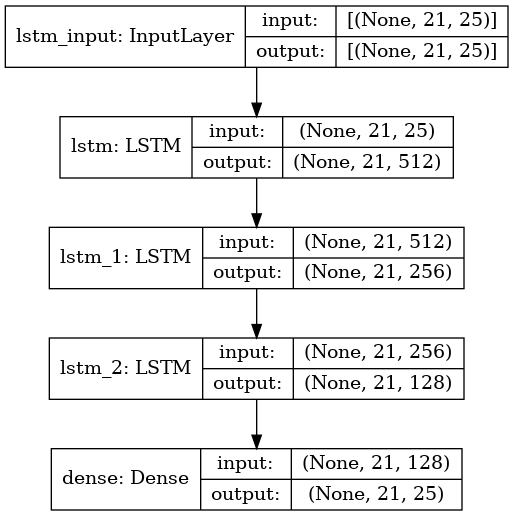

In [21]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(x, y , train_size = 0.8, random_state = 11)

In [23]:
model.fit(x, y, batch_size = 32, epochs = 100)

2022-01-18 15:05:15.136856: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
138/138 [==============================] - 30s 171ms/step - loss: 2.2115 - accuracy: 0.2736
Epoch 2/100
138/138 [==============================] - 24s 171ms/step - loss: 2.1503 - accuracy: 0.3369
Epoch 3/100
138/138 [==============================] - 23s 167ms/step - loss: 2.1322 - accuracy: 0.3475
Epoch 4/100
138/138 [==============================] - 24s 171ms/step - loss: 2.1243 - accuracy: 0.3527
Epoch 5/100
138/138 [==============================] - 24s 171ms/step - loss: 2.1174 - accuracy: 0.3551
Epoch 6/100
138/138 [==============================] - 23s 166ms/step - loss: 2.1145 - accuracy: 0.3582
Epoch 7/100
138/138 [==============================] - 24s 172ms/step - loss: 2.1087 - accuracy: 0.3592
Epoch 8/100
138/138 [==============================] - 24s 172ms/step - loss: 2.1042 - accuracy: 0.3590
Epoch 9/100
138/138 [==============================] - 24s 172ms/step - loss: 2.0987 - accuracy: 0.3195
Epoch 10/100
138/138 [==============================] - 23s 165m

In [24]:
def vectorizer(sentence):
    
    x = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x[0, t, char_indices[char]] = 1
    return x


In [25]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    ls = []
    for i in range(preds.shape[0]):
        a = np.log(preds[i]) / temperature
        exp_preds = np.exp(a)
        a = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, a, size = 1)
        probas = np.asarray(probas[0])
        residue = indices_char[np.argmax(probas, axis = -1).astype(int)]
        
        if residue == '\n':
            break
        else:
            ls.append(residue)
    

    return ls


In [26]:
novel_seq = []

for i in range(x.shape[0]):
    pred = model.predict(x[i].reshape(1, maxlen, len(chars)))
    pred = sample(pred.reshape(maxlen, len(chars)))
    novel_seq.append(pred)

In [27]:
len(novel_seq)

4409

<hr>

<hr>

# classification model

## Data 

In [28]:
# Negative Sequences

df_class_amp = pd.read_csv('../input/anti-microbial-peptides-data/Datasets/Classification model dataset/classification_sequences_amp.csv', names = ['PepSeq', 'MIC'])
df_class_uniprot = pd.read_csv('../input/anti-microbial-peptides-data/Datasets/Classification model dataset/classification_sequences_uniprot.csv', names = ['PepSeq', 'MIC'])

df_class_pos = pd.read_csv('../input/anti-microbial-peptides-data/Datasets/Generative model dataset/amp_dataset.csv', names = ['PepSeq', 'MIC'])

In [29]:
# Positive Sequences 
print("AMP Sequences")
len(sentences)

AMP Sequences


4409

In [30]:
print('Vectorization...')
x_pos = np.zeros((len(sentences), maxlen, len(chars)))

y_pos = np.zeros((len(sentences), 1))

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x_pos[i, t, char_indices[char]] = 1

for i, next_char in enumerate(sentences):
    y_pos[i] = 1


Vectorization...


In [31]:
neg_sentences = df_class_amp.PepSeq
neg_sentences = neg_sentences.append(df_class_uniprot.PepSeq)

In [32]:
print("Non AMP Sequences")
len(neg_sentences)

Non AMP Sequences


3499

In [33]:
print('Vectorization...')
x_neg = np.zeros((len(neg_sentences), maxlen, len(chars)))

y_neg = np.zeros((len(neg_sentences), 1))

for i, sentence in enumerate(neg_sentences):
    for t, char in enumerate(sentence):
        x_neg[i, t, char_indices[char]] = 1

for i, next_char in enumerate(neg_sentences):
    y_neg[i] = 0


Vectorization...


In [34]:
print('Vectorization...')
x_novel = np.zeros((len(novel_seq), maxlen, len(chars)))


for i, sentence in enumerate(novel_seq):
    for t, char in enumerate(sentence):
        x_novel[i, t, char_indices[char]] = 1

Vectorization...


In [35]:
X_class = np.concatenate([x_neg, x_pos])
Y_class = np.concatenate([y_neg, y_pos])

<AxesSubplot:ylabel='count'>

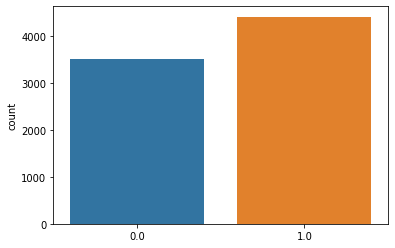

In [36]:
import seaborn as sns

sns.countplot(Y_class.reshape(-1, ))

In [37]:
from sklearn.model_selection import train_test_split
X_class_train, X_class_val, Y_class_train, Y_class_val = train_test_split(X_class, Y_class, train_size = 0.8, random_state = 11)

## Classification Model

In [38]:
print('Build models...')

class_model = Sequential()

class_model.add(LSTM(512, input_shape=(maxlen, len(chars)), return_sequences = True))
class_model.add(LSTM(256, return_sequences = True))
class_model.add(tf.keras.layers.Flatten())
# class_model.add(Dense(512, activation = 'relu'))
class_model.add(Dense(1, activation = 'sigmoid'))

 

print("Build Successful.")
print("Compiling Models...")

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
class_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
    
print("Compile Successful.")

Build models...
Build Successful.
Compiling Models...
Compile Successful.


In [39]:
class_his = class_model.fit(X_class_train, Y_class_train, batch_size = 16, epochs = 25, validation_data = (X_class_val, Y_class_val))

Epoch 1/25
396/396 [==============================] - 46s 106ms/step - loss: 0.6578 - accuracy: 0.6532 - val_loss: 0.5696 - val_accuracy: 0.7162
Epoch 2/25
396/396 [==============================] - 42s 106ms/step - loss: 0.5707 - accuracy: 0.7068 - val_loss: 0.5767 - val_accuracy: 0.7288
Epoch 3/25
396/396 [==============================] - 42s 105ms/step - loss: 0.5025 - accuracy: 0.7743 - val_loss: 0.4626 - val_accuracy: 0.7914
Epoch 4/25
396/396 [==============================] - 42s 107ms/step - loss: 0.4135 - accuracy: 0.8214 - val_loss: 0.4037 - val_accuracy: 0.8249
Epoch 5/25
396/396 [==============================] - 43s 109ms/step - loss: 0.3822 - accuracy: 0.8381 - val_loss: 0.3817 - val_accuracy: 0.8401
Epoch 6/25
396/396 [==============================] - 42s 105ms/step - loss: 0.3511 - accuracy: 0.8535 - val_loss: 0.3681 - val_accuracy: 0.8439
Epoch 7/25
396/396 [==============================] - 42s 106ms/step - loss: 0.3256 - accuracy: 0.8637 - val_loss: 0.3796 - val_ac

In [40]:
y_novel = []

for i in range(x_novel.shape[0]):
    
    a = class_model.predict(x_novel[i].reshape(1,maxlen, len(chars)))
    y_novel.append(a[0][0])

In [41]:
y_05 = [i for i in y_novel if i >= 0.9]

In [42]:
len(y_05)

3676

---
---
---
---
---
---
---
---
---
---


In [43]:






# # In below cell we will make dataset for 6 classification model

# - 1st model : This Model will be trained on positive data having MIC <= 100 and negative data from AMP database
# - 2nd model : This Model will be trained on positive data having MIC <= 50 and negative data from AMP database
# - 3rd model : This Model will be trained on positive data having MIC <= 10 and negative data from AMP database
# - 4th model : This Model will be trained on positive data having MIC <= 100 and negative data from uniprot database
# - 5th model : This Model will be trained on positive data having MIC <= 50 and negative data from uniprot database
# - 6th model : This Model will be trained on positive data having MIC <= 10 and negative data from uniprot database








# tqdm.pandas()

# sequences_pos_100 = list(df_class_pos[df_class_pos.MIC <= 100].PepSeq.progress_apply(splitter))
# sequences_neg_amp_100 = list(df_class_amp[df_class_amp.MIC <= 100].PepSeq.progress_apply(splitter))
# sequences_neg_uniprot_100 = list(df_class_uniprot[df_class_uniprot.MIC <= 100].PepSeq.progress_apply(splitter))


# sequences_pos_50 = list(df_class_pos[df_class_pos.MIC <= 50].PepSeq.progress_apply(splitter))
# sequences_neg_amp_50 = list(df_class_amp[df_class_amp.MIC <= 50].PepSeq.progress_apply(splitter))
# sequences_neg_uniprot_50 = list(df_class_uniprot[df_class_uniprot.MIC <= 50].PepSeq.progress_apply(splitter))


# sequences_pos_10 = list(df_class_pos[df_class_pos.MIC <= 10].PepSeq.progress_apply(splitter))
# sequences_neg_amp_10 = list(df_class_amp[df_class_amp.MIC <= 10].PepSeq.progress_apply(splitter))
# sequences_neg_uniprot_10 = list(df_class_uniprot[df_class_uniprot.MIC <= 10].PepSeq.progress_apply(splitter))




# print(f"Positive data having MIC <= 100 : {len(sequences_pos_100)}")
# print(f"Positive data having MIC <= 50 : {len(sequences_pos_50)}")
# print(f"Positive data having MIC <= 10 : {len(sequences_pos_10)}")
# print(f"Negative data from AMP Database having MIC <= 100 : {len(sequences_neg_amp_100)}")
# print(f"Positive data from AMP Database having MIC <= 50 : {len(sequences_neg_amp_50)}")
# print(f"Positive data from AMP Database having MIC <= 10 : {len(sequences_neg_amp_10)}")
# print(f"Negative data from uniprot Database having MIC <= 100 : {len(sequences_neg_uniprot_100)}")
# print(f"Positive data from uniprot Database having MIC <= 50 : {len(sequences_neg_uniprot_50)}")
# print(f"Positive data from uniprot Database having MIC <= 10 : {len(sequences_neg_uniprot_10)}")





# def vectorizer(sequences, class_):
    
#     x = np.zeros((len(sequences), maxlen, len(chars)))
#     y = np.zeros((len(sequences), 1))

#     for i, sequence in enumerate(sequences):
#         for t, char in enumerate(sequence):
#             x[i, t, char_indices[char]] = 1
    
#     if class_ == 1:
#         for i, _ in enumerate(sequences):
#             y[i] = 1
    
#     elif class_ == 0:
#         for i, _ in enumerate(sequences):
#             y[i] = 0
        
#     return x, y








# x_pos_100, y_pos_100 = vectorizer(sequences_pos_100, 1)
# x_pos_50, y_pos_50 = vectorizer(sequences_pos_50, 1)
# x_pos_10, y_pos_10 = vectorizer(sequences_pos_10, 1)

# x_neg_amp_100, y_neg_amp_100 = vectorizer(sequences_neg_amp_100, 0)
# x_neg_amp_50, y_neg_amp_50 = vectorizer(sequences_neg_amp_50, 0)
# x_neg_amp_10, y_neg_amp_10 = vectorizer(sequences_neg_amp_10, 0)

# x_neg_uniprot_100, y_neg_uniprot_100 = vectorizer(sequences_neg_uniprot_100, 0)
# x_neg_uniprot_50, y_neg_uniprot_50 = vectorizer(sequences_neg_uniprot_50, 0)
# x_neg_uniprot_10, y_neg_uniprot_10 = vectorizer(sequences_neg_uniprot_10, 0)









# x_amp_100 = np.concatenate([x_pos_100, x_neg_amp_100], axis = 0)
# x_amp_50 = np.concatenate([x_pos_50, x_neg_amp_50], axis = 0)
# x_amp_10 = np.concatenate([x_pos_10, x_neg_amp_10], axis = 0)

# y_amp_100 = np.concatenate([y_pos_100, y_neg_amp_100], axis = 0)
# y_amp_50 = np.concatenate([y_pos_50, y_neg_amp_50], axis = 0)
# y_amp_10 = np.concatenate([y_pos_10, y_neg_amp_10], axis = 0)

# x_uniprot_100 = np.concatenate([x_pos_100, x_neg_uniprot_100], axis = 0)
# x_uniprot_50 = np.concatenate([x_pos_50, x_neg_uniprot_50], axis = 0)
# x_uniprot_10 = np.concatenate([x_pos_10, x_neg_uniprot_10], axis = 0)

# y_uniprot_100 = np.concatenate([y_pos_100, y_neg_uniprot_100], axis = 0)
# y_uniprot_50 = np.concatenate([y_pos_50, y_neg_uniprot_50], axis = 0)
# y_uniprot_10 = np.concatenate([y_pos_10, y_neg_uniprot_10], axis = 0)




# def get_class_model():
#     model = Sequential()
#     model.add(LSTM(512, input_shape=(maxlen, len(chars))))
#     model.add(LSTM(256, return_sequences = True))
#     model.add(tf.keras.layers.Flatten())
#     model.add(Dense(512, activation = 'relu'))
#     model.add(Dense(1, activation = 'sigmoid'))
    
# #     model.name(stname)
    
#     return model






# all_data = [(x_amp_100, y_amp_100), (x_amp_50, y_amp_50), (x_amp_10, y_amp_10), (x_uniprot_100, y_uniprot_100), (x_uniprot_50, y_uniprot_50), (x_uniprot_10, y_uniprot_10)]
# models_name = ['model_amp_100', 'model_amp_50', 'model_amp_10', 'model_uniprot_100', 'model_uniprot_50', 'model_uniprot_10']

# class_history = {}
# class_models = {}
# for m, data in zip(models_name, all_data):
#     X_class_train, X_class_val, Y_class_train, Y_class_val = train_test_split(data[0], data[1], train_size = 0.8, random_state = 11)    
    
#     model = get_class_model()
#     optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
#     print(f"*********************************************************************************************")    
#     print(f"*************************** Training of Model {m} Starts ************************************")
#     class_his = model.fit(X_class_train, Y_class_train, batch_size = 16, epochs = 25, validation_data = (X_class_val, Y_class_val))
        
#     class_models[m] = model
#     class_history[m] = class_his
#     print(f"*********************************************************************************************")    
#     print(f"*************************** Training of Model {m} Ends ************************************")